# LAB 5: Clustering and Dimentionality Reduction

> ## IMPORTANT: DO NOT RE RUN THE TRAINING SECTION CODE, USE THE SAVED MODELS INSTEAD TO SAVE TIME !

<div class="alert alert-block alert-danger">
    
1. Download the CIFAR-10 dataset (images) from Kaggle (https://www.kaggle.com/c/cifar-10/) and describe this dataset.
2. Use the Principal Component Analysis,  Kernel Principal Component Analysis, Non-Negative Matrix Factorization, and Singular Value Decomposition for dimentionnality reduction.
3. Train the K-means algorithm on the data before and after dimentionality reduction based on the different techniques.
4. Compare the results in terms of Davies-Bouldin index,silhouette coefficient, accuracy, and F1-score. What do you observe?
4. Use the PCA-based visualization technique (3D components) to visualize the clustering results.
6- Display some images for each cluster (for the best model).

<div/>

<div class="alert alert-block alert-success" style="text-align: center;">
    <b>Solution</b>
<div/>

#### • Import the Necessary Packages

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import davies_bouldin_score, silhouette_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA, KernelPCA, NMF, TruncatedSVD
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
from joblib import load, dump
from PIL import Image
import csv
import os

In [3]:
import sys
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

#### • Data Loading

In [4]:
df = pd.read_csv('cifar-10/trainLabels.csv')

## 1) Describing the dataset

In [5]:
df.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [6]:
df.describe()

,id
count,50000.000000
mean,25000.500000
std,14433.901067
min,1.000000
25%,12500.750000
50%,25000.500000
75%,37500.250000
max,50000.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      50000 non-null  int64 
 1   label   50000 non-null  object
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [8]:
df['label'].value_counts()

label
frog          5000
truck         5000
deer          5000
automobile    5000
bird          5000
horse         5000
ship          5000
cat           5000
dog           5000
airplane      5000
Name: count, dtype: int64

#### • Label Count Plot

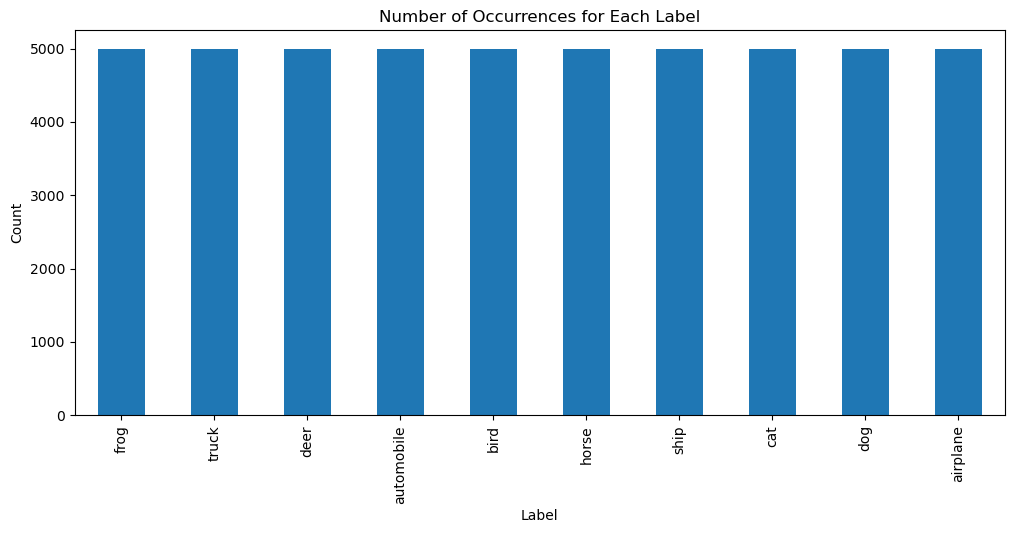

In [9]:
label_counts = df['label'].value_counts()

plt.figure(figsize=(12, 5))
label_counts.plot(kind='bar')
plt.title('Number of Occurrences for Each Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

#### • Displaying One Image from Each Label

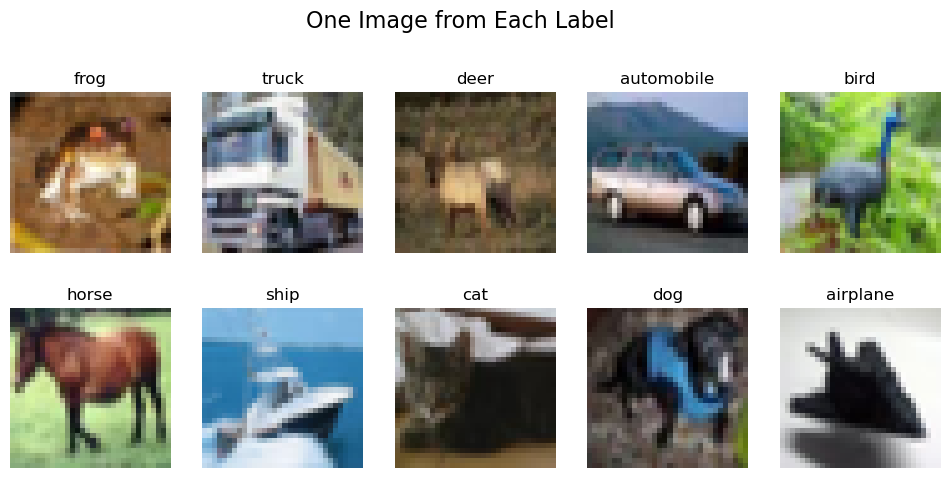

In [15]:
images_directory = 'cifar-10/train'

label_image_dict = {}

for label in df['label'].unique():
    image_id = df[df['label'] == label]['id'].iloc[0]  # Get the first image ID for each label
    image_path = f"{images_directory}/{image_id}.png"
    label_image_dict[label] = image_path

plt.figure(figsize=(12, 5))

for i, (label, image_path) in enumerate(label_image_dict.items()):
    plt.subplot(2, 5, i + 1)
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.text(0.5, 1, 'One Image from Each Label', ha='center', va='bottom', fontsize=16, transform=plt.gcf().transFigure)
plt.subplots_adjust(top=0.9) 
plt.show()

## 2) Dimentionality Reduction

#### • K-means Clustering

In [15]:
def kmeans_clustering(X, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    dump(kmeans, 'kmeans_model.joblib')
    return kmeans

#### • K-means Clustering with Dimensionality Reduction

In [16]:
def perform_dimensionality_reduction(X, reduction_type=None, n_components=None, n_clusters=10):
    # Define the dimensionality reduction technique
    if reduction_type == 'pca':
        reduction_model = PCA(n_components=n_components)
    elif reduction_type == 'kernel_pca':
        reduction_model = KernelPCA(n_components=n_components)
    elif reduction_type == 'nmf':
        reduction_model = NMF(n_components=n_components)
    elif reduction_type == 'svd':
        reduction_model = TruncatedSVD(n_components=n_components)
    else:
        raise ValueError("Invalid reduction_type. Supported types are 'pca', 'kernel_pca', 'nmf', 'svd'.")

    # K-means clustering
    kmeans = kmeans_clustering(n_clusters=n_clusters)

    # Min-Max scaler
    scaler = MinMaxScaler()

    # Create a pipeline with dimensionality reduction and clustering
    pipeline = Pipeline([
        #('scaler', scaler),
        ('reduction', reduction_model),
        ('kmeans', kmeans)
    ])

    # Fit the pipeline to the data
    pipeline.fit(X)

    # Save the pipeline
    model_filename = f'{reduction_type}_kmeans_model.joblib'
    dump(pipeline, model_filename)
    
    return pipeline

> <b><i> Before we move to training we must first determine the number of components</i> </b>

#### • Images Loading

In [19]:
def load_cifar10_images(folder_path):
    image_data = []
    labels = []
    image_files = os.listdir(folder_path)

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        if image_file.lower().endswith(".png"):
            image = Image.open(image_path)
            image_array = np.array(image)
            flattened_image = image_array.flatten()
            image_data.append(flattened_image)

    image_data = np.array(image_data)

    return image_data

#### • Images Preprocessing

In [20]:
def preprocess_images(images):
    # Flatten each image
    flattened_images = images.reshape(images.shape[0], -1)
    
    # Standardize the data
    standardized_images = StandardScaler().fit_transform(flattened_images)
    
    return standardized_images

In [21]:
cifar10_folder_path = "cifar-10/train"
X = load_cifar10_images(cifar10_folder_path)
X_preprocessed = preprocess_images(X)

#### • Determine the Number of Components

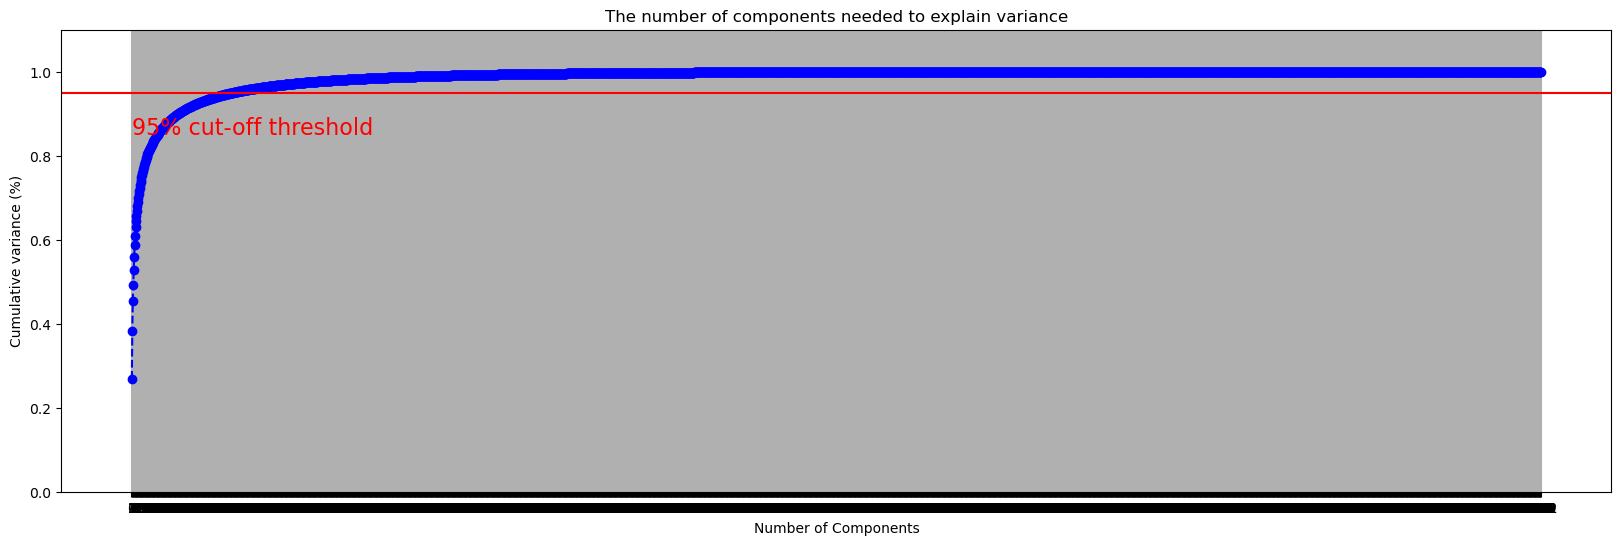

In [15]:
pca = PCA().fit(X_preprocessed)

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,6)

fig, ax = plt.subplots()
xi = np.arange(1,X.shape[1]+1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, X.shape[1]+1, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [16]:
target_variance = 0.95
n_components = np.argmax(y >= target_variance) + 1

print(f"Number of components explaining {target_variance*100:.2f}% of variance: {n_components}")

Number of components explaining 95.00% of variance: 221


## 3) K-Means Training

#### • K-means Training Before Dimentionality Reduction

In [50]:
cluster_labels = kmeans_clustering(X_preprocessed, n_clusters=10)

  File "C:\Users\ACER\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\ACER\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ACER\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\ACER\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


#### • K-means Training After Dimentionality Reduction

In [54]:
# PCA
cluster_labels_pca = perform_dimensionality_reduction(X_preprocessed, reduction_type='pca', n_components=n_components, n_clusters=10)

In [55]:
# SVD
cluster_labels_svd = perform_dimensionality_reduction(X_preprocessed, reduction_type='svd', n_components=n_components, n_clusters=10)

In [47]:
# NMF
cluster_labels_nmf = perform_dimensionality_reduction(X_preprocessed, reduction_type='nmf', n_components=n_components, n_clusters=10)

#### • Models Loading

In [22]:
models = {
    'kmeans': load('kmeans_model.joblib'),
    'pca': load('pca_kmeans_model.joblib'),
    'svd': load('svd_kmeans_model.joblib'),
    'nmf': load('nmf_kmeans_model.joblib')
}

#### • Test PCA Labels Prediction

In [23]:
pca_cluster_labels = models['pca'].predict(X_preprocessed)
pca_cluster_labels

array([3, 5, 4, ..., 5, 0, 6])

#### • Mapping the Labels

In [24]:
y = df['label']

In [25]:
def map_clusters_to_labels(labels, clusters):
    values = np.unique(clusters)
    lookup = {}
    
    for value in values:
        _values, _counts = np.unique(labels[clusters == value], return_counts=True)
        label = _values[_counts.argmax()]
        lookup[value] = label
    
    mapped_labels = np.array([lookup[val] for val in clusters])
    return mapped_labels

## 4) Results Comparing & Evaluation 

#### • Models Evaluation

In [26]:
def evaluate(models, X, y, super_metrics, unsuper_metrics):
    columns = list(super_metrics.keys()) + list(unsuper_metrics.keys())
    index = list(models.keys())
    results = []

    for model_name, model in models.items():
        scores = []
        clusters = model.predict(X)
        labels = map_clusters_to_labels(y, clusters)  # Map clusters to labels

        # Calculate supervised metrics
        for metric_name, metric in super_metrics.items():
            if metric_name == 'Micro F1 Score':
                value = metric(y_true=y, y_pred=labels, average='micro')
            elif metric_name == 'Macro F1 Score':
                value = metric(y_true=y, y_pred=labels, average='macro')
            else:
                value = metric(y_true=y, y_pred=labels)
            scores.append(value)

        # Calculate unsupervised metrics
        for metric_name, metric in unsuper_metrics.items():
            value = metric(X, clusters)
            scores.append(value)

        results.append(scores)

    return pd.DataFrame(results, index=index, columns=columns)

In [24]:
super_metrics = {'Accuracy': accuracy_score, 'Micro F1 Score': f1_score, 'Macro F1 Score': f1_score}
unsuper_metrics = {'Davies-Bouldin Index': davies_bouldin_score, 'Silhouette Coefficient': silhouette_score}

In [30]:
# The commented code is used to evaluate the models
"""
#results = evaluate(models, X_preprocessed, y, super_metrics, unsuper_metrics)
#results
"""
# We will load a saved version of the results since it takes time to evaluate the models
results = pd.read_csv('Metrics Results.csv')
results

# Note:
# 0 : K-means without Dimensionality Reduction
# 1 : K-means with PCA
# 2 : K-means with SVD
# 3 : K-means with NMF

,Accuracy,Micro F1 Score,Macro F1 Score,Davies-Bouldin Index,Silhouette Coefficient
0,0.10604,0.10604,0.072905,2.826007,0.047252
1,0.10616,0.10616,0.073866,2.828090,0.047736
2,0.10586,0.10586,0.073665,2.823005,0.047460
3,0.10602,0.10602,0.065645,5.585897,-0.068558


#### • Save the Results

In [31]:
results.to_csv('Metrics Results.csv', index=False)

## 5) PCA-based visualization 

#### K-means

In [33]:
y_predNONE = models['kmeans'].predict(X_preprocessed)

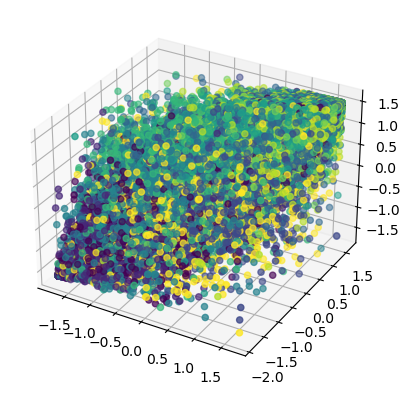

In [50]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_preprocessed[:, 0], X_preprocessed[:, 1], X_preprocessed[:,2], c=y_predNONE)
plt.show()

#### K-means with PCA

In [36]:
y_predPCA = models['pca'].predict(X_preprocessed)

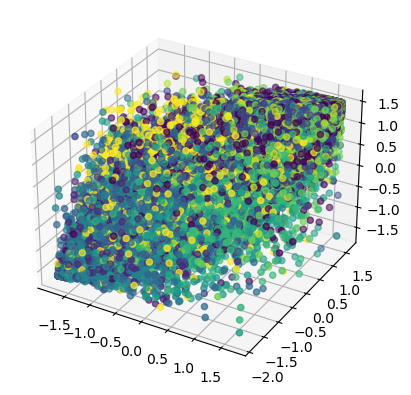

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_preprocessed[:, 0], X_preprocessed[:, 1], X_preprocessed[:,2], c=y_predPCA)
plt.show()

#### K-means with SVD

In [31]:
y_predSVD = models['svd'].predict(X_preprocessed)

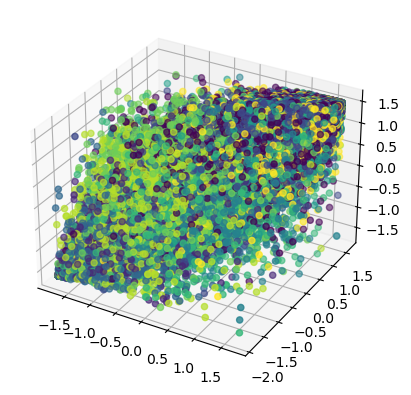

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_preprocessed[:, 0], X_preprocessed[:, 1], X_preprocessed[:,2], c=y_predSVD)
plt.show()

#### K-means with NMF

In [30]:
y_predNMF = models['nmf'].predict(X_preprocessed)

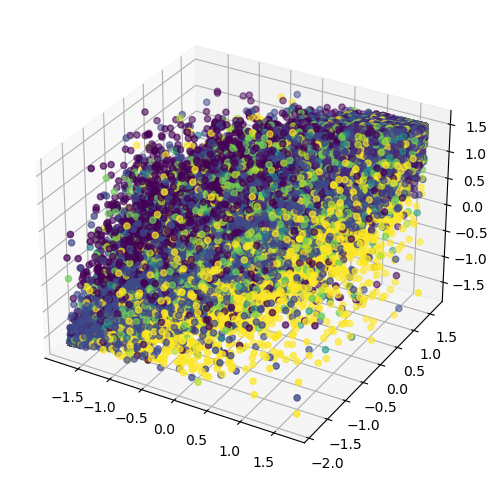

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_preprocessed[:, 0], X_preprocessed[:, 1], X_preprocessed[:,2], c=y_predNMF)
plt.show()

## 6) Display Some Images for Each Cluster

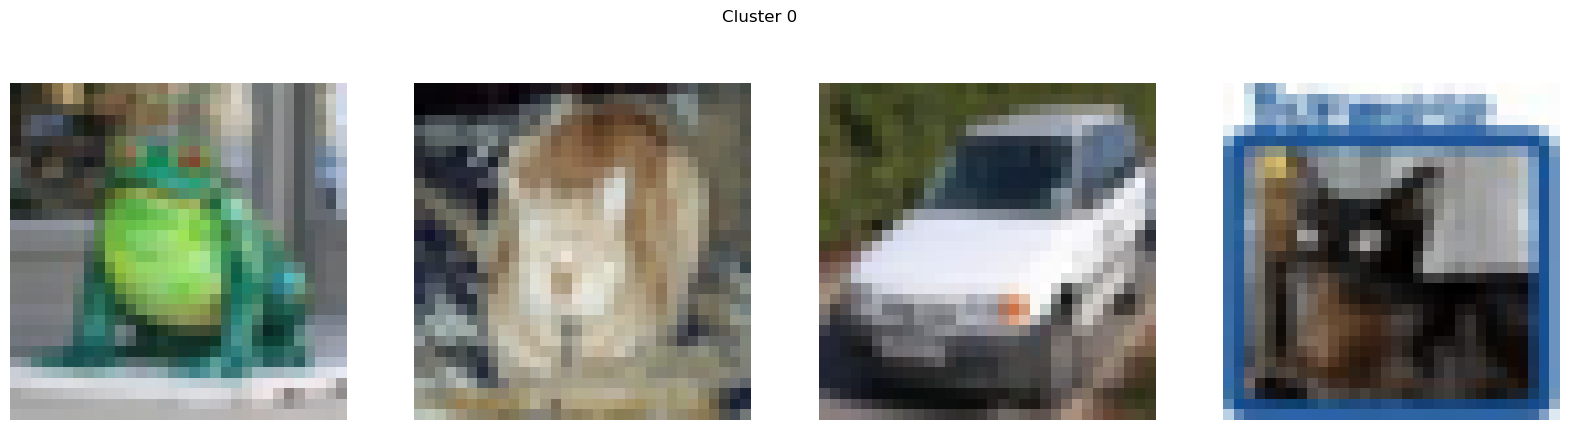

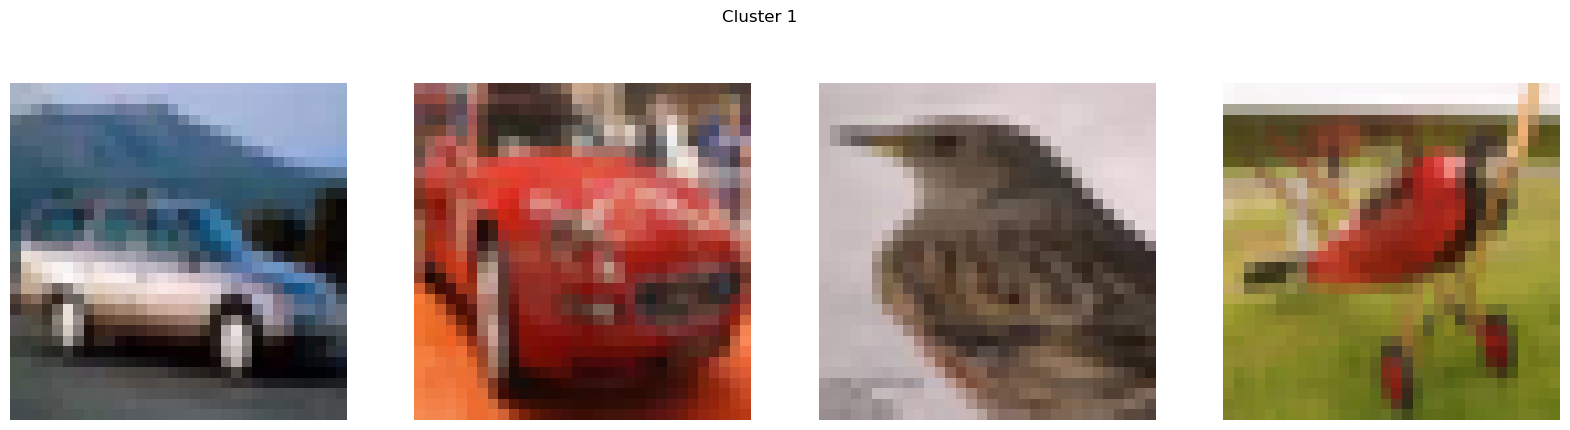

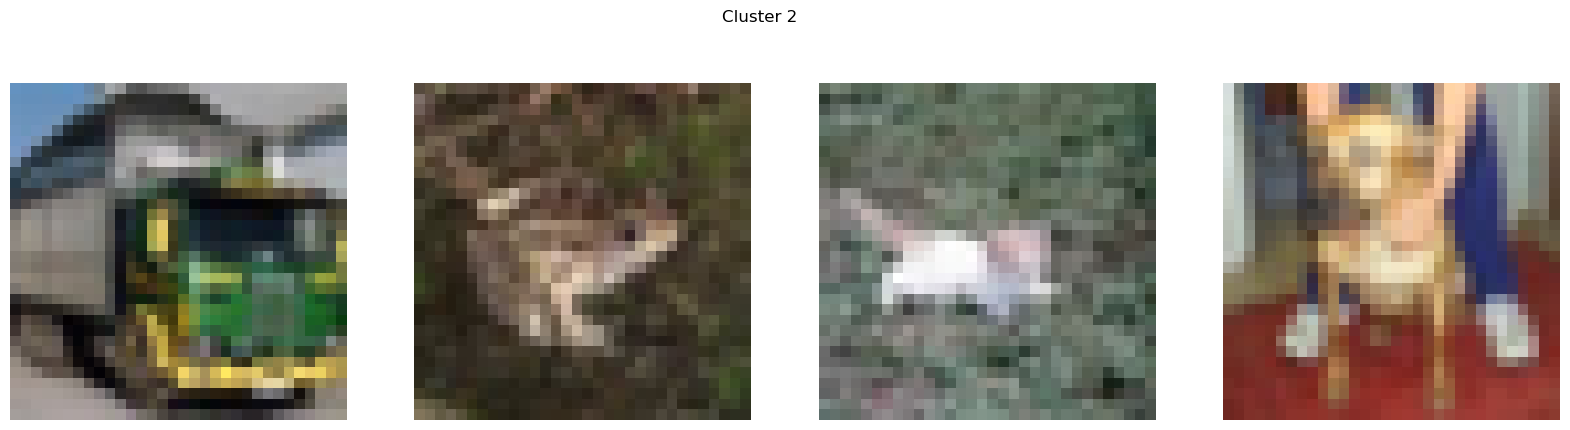

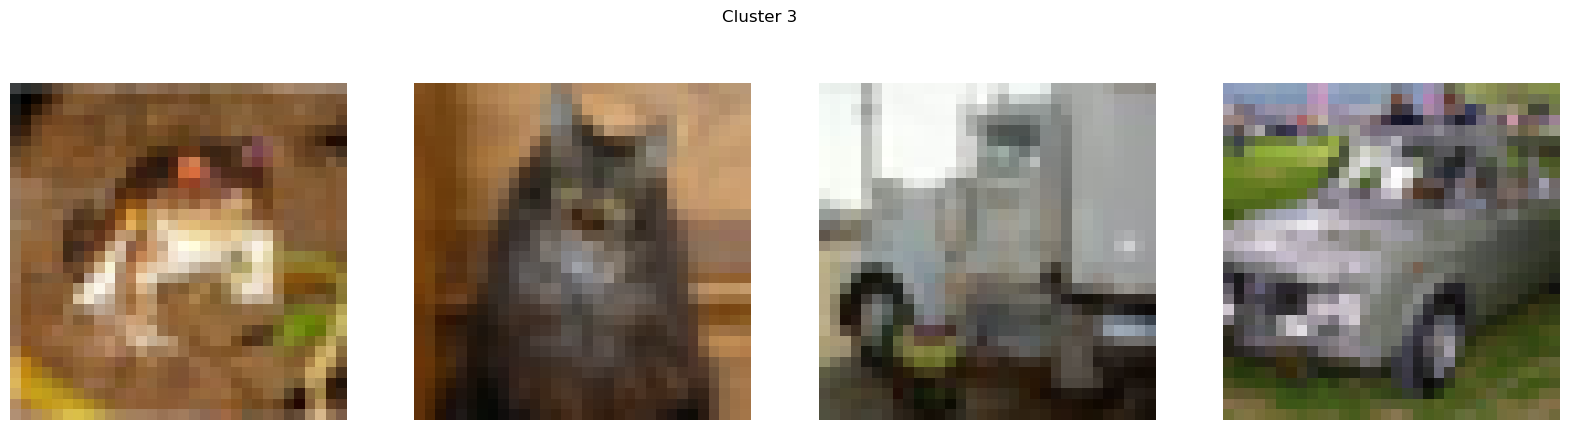

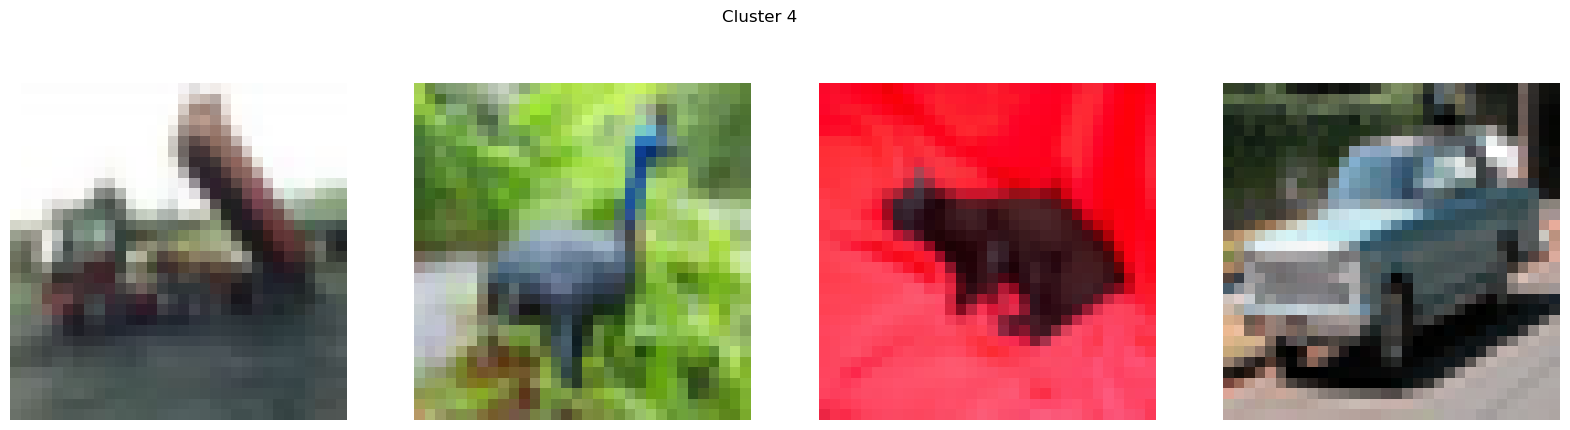

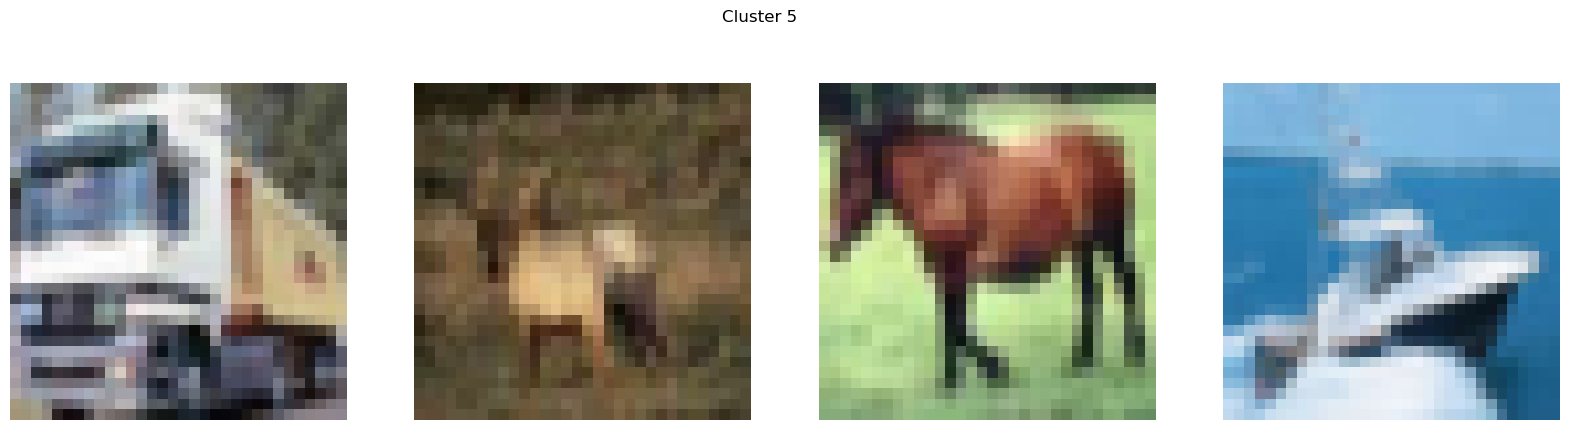

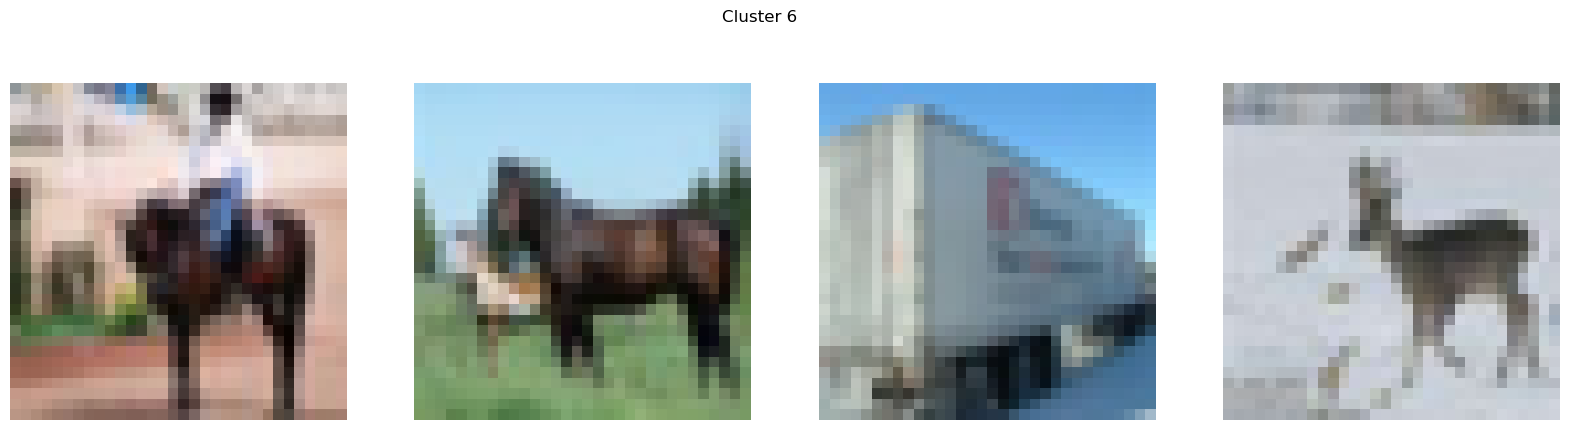

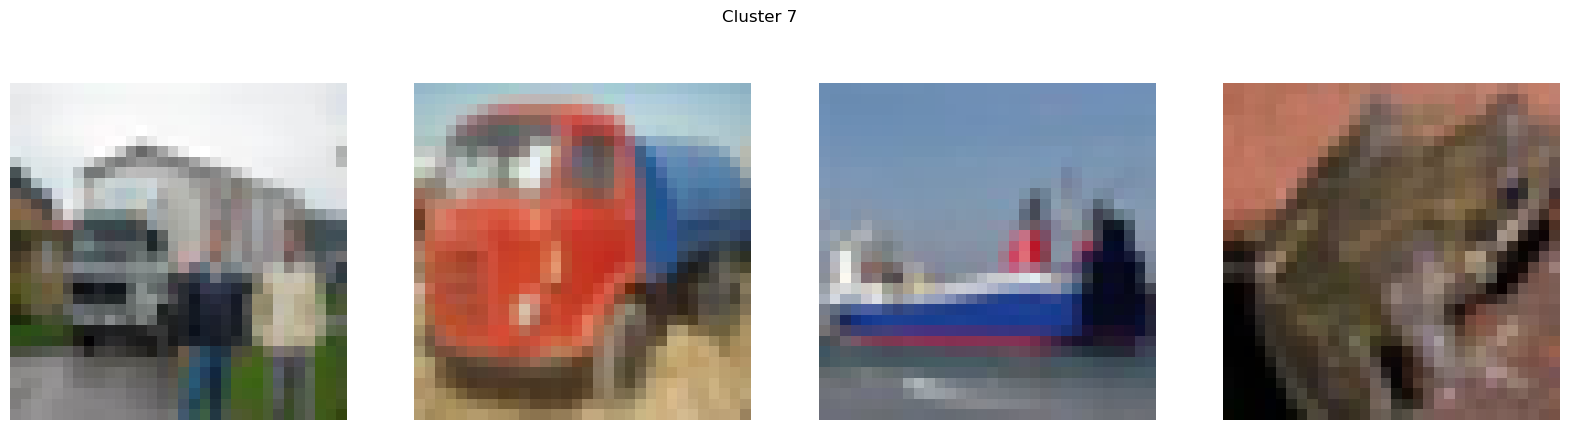

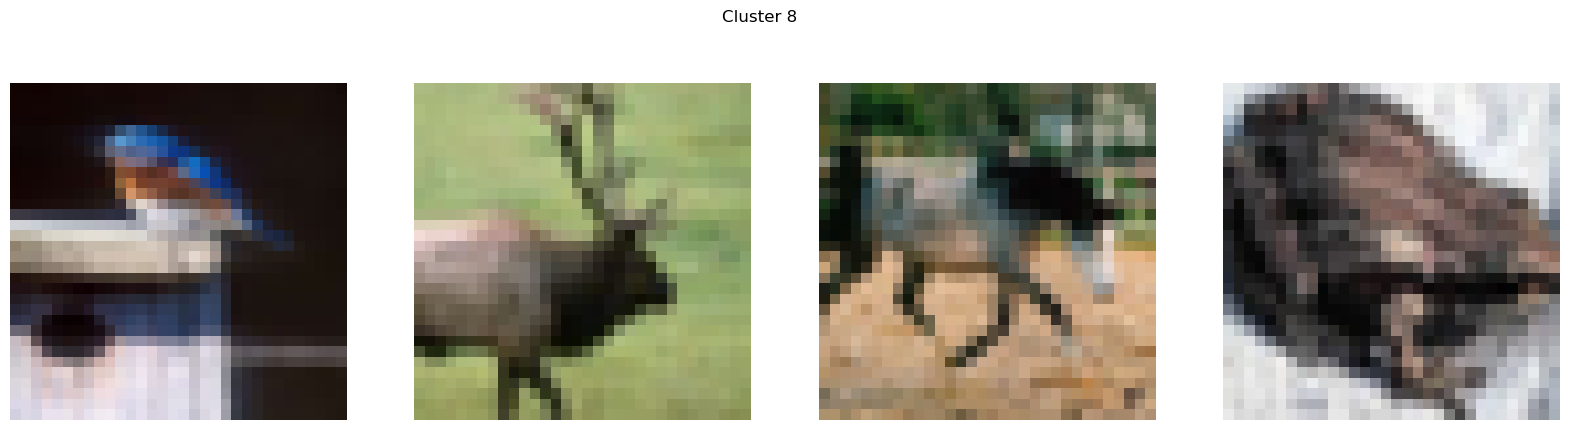

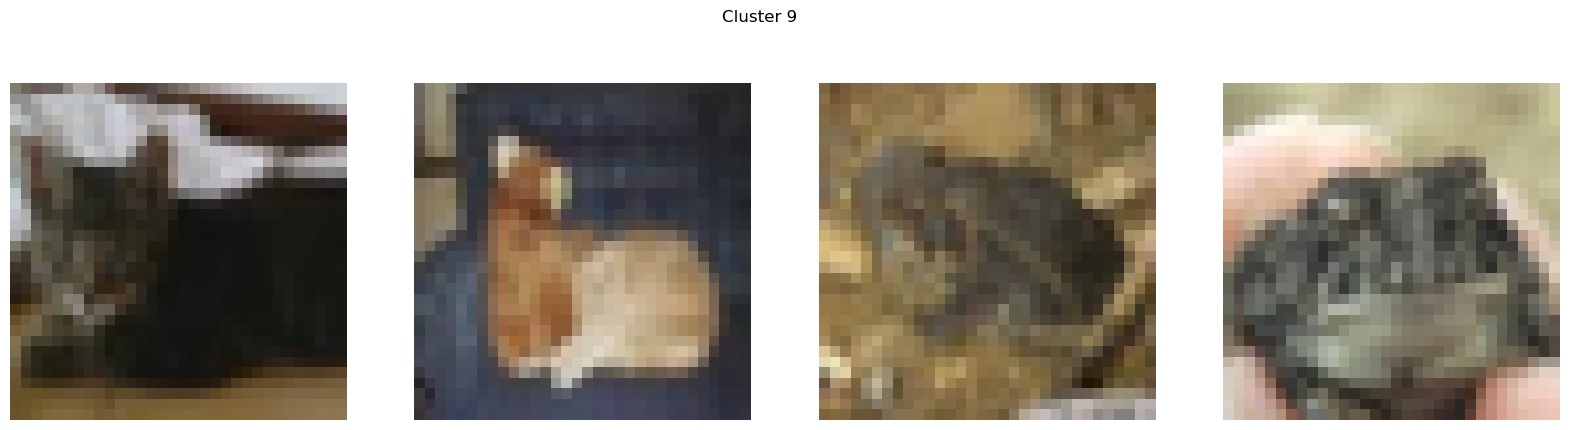

In [39]:
 for i in range(10):
    cluster_indices = np.where(y_predPCA == i)[0]
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    for j in range(4):
        image = df['id'][cluster_indices[j]]
        img = Image.open('cifar-10/train/'+str(image)+'.png')
        axs[j].imshow(img)
        axs[j].axis('off')
    plt.suptitle(f'Cluster {i}')
    plt.show()